# MSCA 31009 Machine Learning & Predictive Analytics
## Final Project - Deep Learning Based Steam Store Game Recommender System
### Modelling
Shijia Huang

-----

In [1]:
# Import basic libraries
import sys
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Import model libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error,classification_report

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, utils, optimizers, regularizers
from keras.models import Sequential, load_model
from keras.utils import plot_model

import re

2023-05-20 16:21:56.620431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [4]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


## Data Preparation

### Load Games Data

In [5]:
# read in the feaure engineered data
games_df = pd.read_csv('feat/games_detail.csv')
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39677 entries, 0 to 39676
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   app_id              39677 non-null  int64  
 1   title               39677 non-null  object 
 2   date_release        39677 non-null  object 
 3   win                 39677 non-null  int64  
 4   mac                 39677 non-null  int64  
 5   linux               39677 non-null  int64  
 6   rating              39677 non-null  int64  
 7   positive_ratio      39677 non-null  int64  
 8   user_reviews        39677 non-null  int64  
 9   price_final         39677 non-null  float64
 10  price_original      39677 non-null  float64
 11  discount            39677 non-null  float64
 12  description         39677 non-null  object 
 13  tags                39677 non-null  object 
 14  Multiplayer         39677 non-null  int64  
 15  Action              39677 non-null  int64  
 16  Shoo

In [6]:
# set index as appid
games_df.set_index('app_id', inplace=True)

In [7]:
games_df.head(2)

,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,description,tags,Multiplayer,Action,Shooter,Singleplayer,First-Person,Horror,Adventure,Atmospheric,Fantasy,Story Rich,Puzzle,Indie,Strategy,Casual,Pixel Graphics,2D,Anime,RPG,Arcade,Retro,Female Protagonist,Simulation,Early Access,Cute,Funny,Exploration,Free to Play,Colorful,3D
app_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10090,Call of Duty: World at War,2008-11-18,1,0,0,3,92,37039,19.99,19.99,0.0,"Call of Duty is back, redefining war like you've never experienced before. Building on the Call of Duty 4®: Modern Warfare engine, Call of Duty: World at War immerses players into the most gritty and chaotic WWII combat ever experienced.","['Zombies', 'World War II', 'FPS', 'Multiplayer', 'Action', 'Shooter', 'Co-op', 'Singleplayer', 'Moddable', 'First-Person', 'War', 'Online Co-Op', 'Gore', 'Historical', 'Classic', 'Survival', 'Great Soundtrack', 'Tanks', 'Horror', 'Adventure']",1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,3,84,2199,9.99,9.99,0.0,"Enter the dark underworld of Prince of Persia Warrior Within, the sword-slashing sequel to the critically acclaimed Prince of Persia: The Sands of Time™. Hunted by Dahaka, an immortal incarnation of Fate seeking divine retribution, the Prince embarks upon a path of both carnage and mystery to defy his preordained death.","['Action', 'Adventure', 'Parkour', 'Third Person', 'Great Soundtrack', 'Singleplayer', 'Platformer', 'Time Travel', 'Atmospheric', 'Classic', 'Hack and Slash', 'Time Manipulation', 'Gore', 'Fantasy', 'Story Rich', 'Dark', 'Open World', 'Controller', 'Dark Fantasy', 'Puzzle']",0,1,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# phrasing the date column
games_df['date_release'] = pd.to_datetime(games_df['date_release'], format='%Y-%m-%d')

### Load User Reviews Data

In [9]:
# read in the subset user review data
users_reviews_df = pd.read_csv('feat/users_reviews_sub.csv')
users_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703470 entries, 0 to 703469
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         703470 non-null  int64  
 1   products        703470 non-null  int64  
 2   reviews         703470 non-null  int64  
 3   app_id          703470 non-null  int64  
 4   helpful         703470 non-null  int64  
 5   funny           703470 non-null  int64  
 6   date            703470 non-null  object 
 7   is_recommended  703470 non-null  int64  
 8   hours           703470 non-null  float64
 9   review_id       703470 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 53.7+ MB


In [10]:
users_reviews_df.head()

,user_id,products,reviews,app_id,helpful,funny,date,is_recommended,hours,review_id
0,2164089,702,35,264710,0,2,2018-05-30,1,33.9,2063767
1,2164089,702,35,239030,0,0,2013-12-12,1,10.3,4517660
2,2164089,702,35,250900,0,0,2017-02-17,1,61.6,5762464
3,2164089,702,35,607080,2,0,2021-12-25,1,19.0,6152399
4,2164089,702,35,335300,2,0,2017-01-01,1,164.0,6410467


In [11]:
# phrasing the date column
users_reviews_df['date'] = pd.to_datetime(users_reviews_df['date'], format='%Y-%m-%d')

## Data Preparation

### User - Game Matrix

In [12]:
user_review_pivot = users_reviews_df.set_index(['user_id', 'app_id'])['is_recommended'].unstack('app_id')
user_review_pivot

app_id   30       60       70       220      400      440      500       
user_id                                                                  
505          NaN      NaN      NaN      1.0      NaN      NaN      NaN  \
1159         NaN      NaN      1.0      NaN      NaN      NaN      NaN   
1292         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1513         NaN      NaN      NaN      NaN      NaN      1.0      NaN   
1526         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...          ...      ...      ...      ...      ...      ...      ...   
6790767      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790874      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790928      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791053      NaN      NaN      NaN      NaN      1.0      NaN      NaN   
6791130      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

app_id   550      570      620      730      1200     1510     1700      
user_id                                                                  
505          NaN      NaN      NaN      NaN      NaN      NaN      NaN  \
1159         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1292         1.0      NaN      1.0      1.0      NaN      NaN      NaN   
1513         1.0      NaN      NaN      NaN      NaN      NaN      NaN   
1526         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...          ...      ...      ...      ...      ...      ...      ...   
6790767      1.0      NaN      NaN      NaN      NaN      NaN      NaN   
6790874      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790928      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791053      NaN      NaN      1.0      NaN      NaN      NaN      NaN   
6791130      1.0      NaN      NaN      1.0      NaN      NaN      NaN   

app_id   3620     3900     4000     4500     4570     4700     4720      
user_id                                                                  
505          NaN      NaN      NaN      NaN      1.0      NaN      NaN  \
1159         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1292         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1513         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1526         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...          ...      ...      ...      ...      ...      ...      ...   
6790767      NaN      NaN      1.0      NaN      NaN      NaN      NaN   
6790874      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790928      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791053      NaN      NaN      NaN      NaN      NaN      NaN      1.0   
6791130      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

app_id   4850     6060     6220     7000     7610     7800     8500      
user_id                                                                  
505          NaN      NaN      NaN      NaN      NaN      NaN      NaN  \
1159         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1292         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1513         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1526         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...          ...      ...      ...      ...      ...      ...      ...   
6790767      NaN      NaN      NaN      1.0      NaN      NaN      NaN   
6790874      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790928      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791053      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791130      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

app_id   8870     8930     8980     9180     9900     10090    10110     
user_id                                                                  


In [13]:
# save the index and columns
user_review_pivot_index = user_review_pivot.index
user_review_pivot_columns = user_review_pivot.columns

In [14]:
# reset the index of the pivot table
user_review_pivot_reindex = pd.DataFrame(user_review_pivot.values, 
                                         index=np.arange(0, len(user_review_pivot_index)), columns=np.arange(0, len(user_review_pivot_columns)))
user_review_pivot_reindex.index.name = 'user_id'
user_review_pivot_reindex.columns.name = 'app_id'

user_review_pivot = user_review_pivot_reindex
user_review_pivot

app_id   0     1     2     3     4     5     6     7     8     9     10     
user_id                                                                     
0         NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  \
1         NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   1.0   1.0   
3         NaN   NaN   NaN   NaN   NaN   1.0   NaN   1.0   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25306     NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   
25307     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25308     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25309     NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   1.0   NaN   
25310     NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   1.0   

app_id   11    12    13    14    15    16    17    18    19    20    21     
user_id                                                                     
0         NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN  \
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25306     NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
25307     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25308     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25309     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   
25310     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

app_id   22    23    24    25    26    27    28    29    30    31    32     
user_id                                                                     
0         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  \
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25306     NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25307     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25308     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25309     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25310     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

app_id   33    34    35    36    37    38    39    40    41    42    43     
user_id                                                                     
0         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  \
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25306     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25307     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25308     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25309     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25310     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

In [15]:
# value count the number of zeros and ones
user_review_pivot_count = user_review_pivot.apply(pd.Series.value_counts, axis=0).sum(axis=1)
user_review_pivot_count

0.0    143616.0
1.0    559854.0
dtype: float64

In [16]:
split = int(np.quantile(user_review_pivot.columns.tolist(), 0.8))
split

1492

In [17]:
# Train
dtf_train = user_review_pivot.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>=0].count().sum())
dtf_train

non-null data: 652081


app_id   0     1     2     3     4     5     6     7     8     9     10     
user_id                                                                     
0         NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  \
1         NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   1.0   1.0   
3         NaN   NaN   NaN   NaN   NaN   1.0   NaN   1.0   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25306     NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   
25307     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25308     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25309     NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   1.0   NaN   
25310     NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   1.0   

app_id   11    12    13    14    15    16    17    18    19    20    21     
user_id                                                                     
0         NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN  \
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25306     NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
25307     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25308     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25309     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   
25310     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

app_id   22    23    24    25    26    27    28    29    30    31    32     
user_id                                                                     
0         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  \
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25306     NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25307     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25308     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25309     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25310     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

app_id   33    34    35    36    37    38    39    40    41    42    43     
user_id                                                                     
0         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  \
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
25306     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25307     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25308     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25309     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25310     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

In [18]:
# Test
dtf_test = user_review_pivot.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>=0].count().sum())
dtf_test

non-null data: 51389


app_id,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [19]:
# select data from games_df where app_id is in user_review_pivot and in the same order
games_cf_df = games_df[games_df.index.isin(user_review_pivot_columns)].sort_values(by=['app_id']).reset_index(drop=True)
games_cf_df.index.name = 'app_id'
games_cf_df.head(2)

,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,description,tags,Multiplayer,Action,Shooter,Singleplayer,First-Person,Horror,Adventure,Atmospheric,Fantasy,Story Rich,Puzzle,Indie,Strategy,Casual,Pixel Graphics,2D,Anime,RPG,Arcade,Retro,Female Protagonist,Simulation,Early Access,Cute,Funny,Exploration,Free to Play,Colorful,3D
app_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Day of Defeat,2003-05-01,1,1,1,3,87,3489,4.99,4.99,0.0,"Enlist in an intense brand of Axis vs. Allied teamplay set in the WWII European Theatre of Operations. Players assume the role of light/assault/heavy infantry, sniper or machine-gunner class, each with a unique arsenal of historical weaponry at their disposal. Missions are based on key historical operations.","['FPS', 'World War II', 'Multiplayer', 'Shooter', 'Action', 'War', 'Team-Based', 'Classic', 'First-Person', 'Class-Based', 'Military', 'Historical', 'Tactical', 'Singleplayer', 'Co-op', 'Difficult', 'Retro', 'Old School', 'Strategy', 'World War I']",1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Ricochet,2000-11-01,1,1,1,3,80,3395,4.99,4.99,0.0,"A futuristic action game that challenges your agility as well as your aim, Ricochet features one-on-one and team matches played in a variety of futuristic battle arenas.","['Action', 'FPS', 'Multiplayer', 'Classic', 'First-Person', 'Sci-fi', 'Shooter', 'Space', 'Cyberpunk', 'Memes', 'Psychological Horror', 'Platformer', 'Conspiracy', '3D', 'Retro', 'Old School', 'Cult Classic', 'Competitive', 'Sports', 'Great Soundtrack']",1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [20]:
games_cf_df = games_cf_df.drop(columns=['title', 'date_release', 'description', 'tags'])
games_cf_df.shape

(1867, 38)

In [21]:
games_cf_df.head(2)

,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,Multiplayer,Action,Shooter,Singleplayer,First-Person,Horror,Adventure,Atmospheric,Fantasy,Story Rich,Puzzle,Indie,Strategy,Casual,Pixel Graphics,2D,Anime,RPG,Arcade,Retro,Female Protagonist,Simulation,Early Access,Cute,Funny,Exploration,Free to Play,Colorful,3D
app_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,3,87,3489,4.99,4.99,0.0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,1,3,80,3395,4.99,4.99,0.0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [22]:
# standardize the data as the values are in different scales
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

games_cf_df_scaled = scaler.fit_transform(games_cf_df)

# convert the array back to dataframe
games_cf_df_scaled = pd.DataFrame(games_cf_df_scaled, index=games_cf_df.index, columns=games_cf_df.columns)
games_cf_df_scaled.head(2)

,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,Multiplayer,Action,Shooter,Singleplayer,First-Person,Horror,Adventure,Atmospheric,Fantasy,Story Rich,Puzzle,Indie,Strategy,Casual,Pixel Graphics,2D,Anime,RPG,Arcade,Retro,Female Protagonist,Simulation,Early Access,Cute,Funny,Exploration,Free to Play,Colorful,3D
app_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,1.0,0.8,0.805970,0.000501,0.062383,0.045368,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.8,0.701493,0.000487,0.062383,0.045368,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Model Exploration

### Baseline Model: Content-Based Filtering

In [23]:
# Select a user
i = 9460
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[train["y"] >= 0]), "| test:", len(test[test["y"] >= 0]))
test.head()

train: 109 | test: 35


,y
app_id,
1492,NaN
1493,0.0
1494,NaN
1495,NaN
1496,NaN


In [24]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = pd.concat([train, tmp])
train.tail()

,y
app_id,
1862,NaN
1863,NaN
1864,NaN
1865,NaN
1866,NaN


In [25]:
train.shape

(1867, 1)

In [26]:
# Model
usr = train[["y"]].fillna(0).values.T
prd = games_cf_df_scaled.values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 1867)  x  Products (1867, 38)


In [27]:
# usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = np.dot(usr, prd)

# normalize
weights = usr_ft / usr_ft.sum()

# predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = np.dot(weights, prd.T)
pred

array([[0.50449043, 0.42317219, 0.6371636 , ..., 0.4639587 , 0.14018543,
        0.35770264]])

In [28]:
# Apply threshold for binary prediction
threshold = 0.5
binary_pred = np.where(pred >= threshold, 1.0, 0.0)
binary_pred = pd.DataFrame(binary_pred[0], columns=["yhat"], index=train.index)
binary_pred

,yhat
app_id,
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
1862,0.0
1863,0.0
1864,0.0


In [29]:
test_pred = test.merge(binary_pred, how="left", left_index=True, right_index=True)
test_pred = test_pred[test_pred["y"] >= 0]
test_pred

,y,yhat
app_id,,
1493,0.0,0.0
1504,0.0,0.0
1511,0.0,0.0
1529,0.0,0.0
1533,0.0,0.0
1547,0.0,0.0
1550,0.0,1.0
1569,0.0,0.0
1618,1.0,1.0


#### Evaluation

In [30]:
# Accuracy
print("Accuracy:", round(accuracy_score(test_pred["y"], test_pred["yhat"]), 2))

Accuracy: 0.77


In [31]:
# Confusion matrix
confusion_matrix(test_pred["y"], test_pred["yhat"])

array([[21,  3],
       [ 5,  6]])

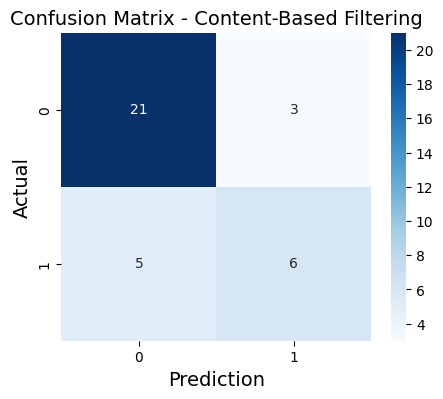

In [32]:
# visualize the confusion matrix with seaborn heatmap
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confusion_matrix(test_pred["y"], test_pred["yhat"]), annot=True, fmt="d", cmap="Blues", cbar=True)
ax.set_xlabel("Prediction", fontsize=14)
ax.set_ylabel("Actual", fontsize=14)
ax.set_title("Confusion Matrix - Content-Based Filtering", fontsize=14)
plt.show()


In [33]:
# classification report
print(classification_report(test_pred["y"], test_pred["yhat"]))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        24
         1.0       0.67      0.55      0.60        11

    accuracy                           0.77        35
   macro avg       0.74      0.71      0.72        35
weighted avg       0.76      0.77      0.76        35



### Collaborative Filtering

In [34]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user_id,app_id,y
0,0,3,1.0
1,0,18,1.0
2,0,55,1.0
3,0,64,1.0
4,0,78,1.0


In [35]:
train.shape

(652081, 3)

In [36]:
train['y'].value_counts()

y
1.0    520072
0.0    132009
Name: count, dtype: int64

In [37]:
# oversampling
from imblearn.over_sampling import RandomOverSampler

X = train[['user_id', 'app_id']]  # Features
y = train['y']  # Target variable

# Create the RandomOverSampler object
over_sampler = RandomOverSampler(sampling_strategy=1, random_state=42)

# Perform the oversampling
X_resampled, y_resampled = over_sampler.fit_resample(X, y)

# View the count of target classes with Counter
from collections import Counter

print(Counter(y_resampled))

Counter({1.0: 520072, 0.0: 520072})


In [38]:
# Create a new DataFrame with the oversampled data
oversampled_data = pd.concat([X_resampled, y_resampled], axis=1)

# show the oversampled data
train = oversampled_data
train

,user_id,app_id,y
0,0,3,1.0
1,0,18,1.0
2,0,55,1.0
3,0,64,1.0
4,0,78,1.0
...,...,...,...
1040139,7886,184,0.0
1040140,25007,145,0.0
1040141,17860,463,0.0
1040142,2158,331,0.0


In [39]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user_id,app_id,y
0,1,1515,1.0
1,1,1536,1.0
2,1,1726,1.0
3,4,1708,1.0
4,5,1530,0.0


In [40]:
test.shape

(51389, 3)

In [41]:
test['y'].value_counts()

y
1.0    39782
0.0    11607
Name: count, dtype: int64

In [42]:
embeddings_size = 30
usr, prd = user_review_pivot.shape[0], user_review_pivot.shape[1]
print("Users", usr, " x  Products", prd)

Users 25311  x  Products 1867


In [43]:
# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(
    name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(
    name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(
    name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(
    name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) and Reshape (,1)
xx = layers.Dot(name='xx', normalize=False, axes=1)([xusers, xproducts])

# Batch Normalization
xx = layers.BatchNormalization()(xx)

# Predict ratings (0,1)
y_out = layers.Dense(name="y_out", units=1, activation='sigmoid')(xx)

# Compile
model = models.Model(inputs=[xusers_in, xproducts_in],
                     outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adamax', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 xusers_emb (Embedding)         (None, 1, 30)        759330      ['xusers_in[0][0]']              
                                                                                                  
 xproducts_emb (Embedding)      (None, 1, 30)        56010       ['xproducts_in[0][0]']           
                                                                             

In [44]:
#!pip install pydot
#!pip install graphviz

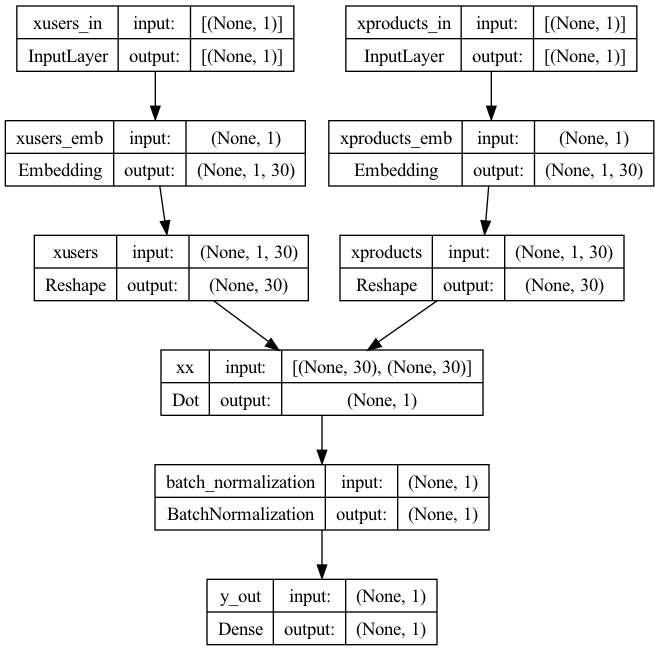

In [45]:
plot_model(model, to_file='cf.png', show_shapes=True, show_layer_names=True)

In [46]:
# train
cf_training = model.fit(x=[train["user_id"], train["app_id"]], y=train["y"],
                     epochs=5, batch_size=128, shuffle=True, verbose=1, validation_data=([test["user_id"], test["app_id"]], test["y"]))

Epoch 1/5
8127/8127 [==============================] - 40s 5ms/step - loss: 0.6649 - accuracy: 0.5842 - val_loss: 0.6522 - val_accuracy: 0.6239
Epoch 2/5
8127/8127 [==============================] - 46s 6ms/step - loss: 0.4768 - accuracy: 0.7771 - val_loss: 0.6248 - val_accuracy: 0.6926
Epoch 3/5
8127/8127 [==============================] - 38s 5ms/step - loss: 0.3384 - accuracy: 0.8607 - val_loss: 0.6396 - val_accuracy: 0.7259
Epoch 4/5
8127/8127 [==============================] - 42s 5ms/step - loss: 0.2551 - accuracy: 0.9024 - val_loss: 0.6873 - val_accuracy: 0.7472
Epoch 5/5
8127/8127 [==============================] - 50s 6ms/step - loss: 0.1997 - accuracy: 0.9284 - val_loss: 0.7494 - val_accuracy: 0.7599


In [47]:
# Plot loss and metrics of keras training.
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

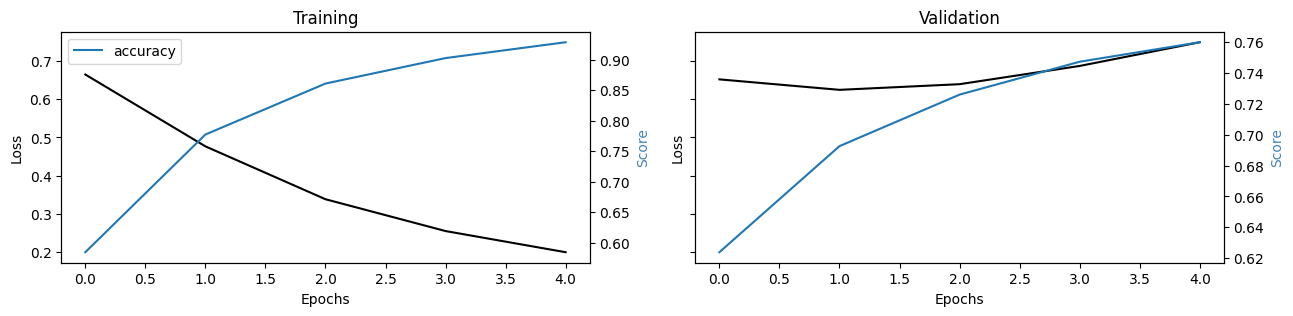

In [48]:
cf_model = cf_training.model
utils_plot_keras_training(cf_training)

In [49]:
# save the model
cf_model.save('cf_model.h5')

In [50]:
# test
threshold = 0.5
pred = cf_model.predict([test["user_id"], test["app_id"]])
binary_pred = np.where(pred >= threshold, 1.0, 0.0)
test["yhat"] = binary_pred
test

1606/1606 [==============================] - 1s 852us/step


,user_id,app_id,y,yhat
0,1,1515,1.0,1.0
1,1,1536,1.0,1.0
2,1,1726,1.0,1.0
3,4,1708,1.0,1.0
4,5,1530,0.0,1.0
...,...,...,...,...
51384,25304,1747,1.0,1.0
51385,25307,1659,0.0,1.0
51386,25309,1556,1.0,1.0
51387,25310,1546,0.0,1.0


#### Evaluation

In [51]:
# get loss and accuracy on test set
results = cf_model.evaluate([test["user_id"], test["app_id"]], test["y"], batch_size=128)
print('test loss: ', results[0])
print('test accuracy: ', results[1])

402/402 [==============================] - 0s 981us/step - loss: 0.7494 - accuracy: 0.7599
test loss:  0.749413788318634
test accuracy:  0.759851336479187


In [52]:
# Confusion matrix
confusion_matrix(test["y"], test["yhat"])

array([[  674, 10933],
       [ 1408, 38374]])

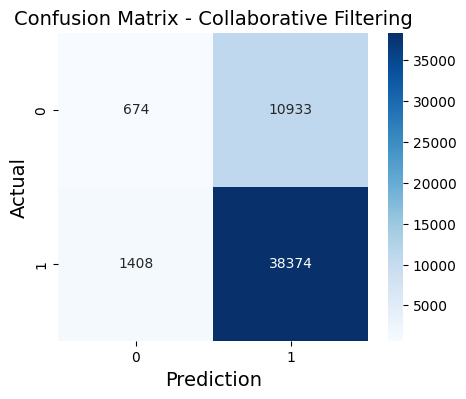

In [53]:
# visualize the confusion matrix with seaborn heatmap
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confusion_matrix(test["y"], test["yhat"]), annot=True, fmt="d", cmap="Blues", cbar=True)
ax.set_xlabel("Prediction", fontsize=14)
ax.set_ylabel("Actual", fontsize=14)
ax.set_title("Confusion Matrix - Collaborative Filtering", fontsize=14)
plt.show()

In [54]:
# classification report
print(classification_report(test["y"], test["yhat"]))

              precision    recall  f1-score   support

         0.0       0.32      0.06      0.10     11607
         1.0       0.78      0.96      0.86     39782

    accuracy                           0.76     51389
   macro avg       0.55      0.51      0.48     51389
weighted avg       0.68      0.76      0.69     51389



### Neural Collaborative Filtering (NCF) with Embeddings

In [55]:
train = oversampled_data
train.head()

,user_id,app_id,y
0,0,3,1.0
1,0,18,1.0
2,0,55,1.0
3,0,64,1.0
4,0,78,1.0


In [56]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user_id,app_id,y
0,1,1515,1.0
1,1,1536,1.0
2,1,1726,1.0
3,4,1708,1.0
4,5,1530,0.0


In [57]:
embeddings_size = 30
usr, prd = user_review_pivot.shape[0], user_review_pivot.shape[1]
print("Users", usr, " x  Products", prd)

Users 25311  x  Products 1867


In [58]:
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y = layers.Concatenate()([cf_xx, nn_xx])

# Add batch normalization
y_batch = layers.BatchNormalization()(y)

# Predict ratings (0,1)
y_out = layers.Dense(name="y_out", units=1, activation='sigmoid')(y_batch)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 30)        759330      ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 30)        56010       ['xproducts_in[0][0]']           
                                                                      

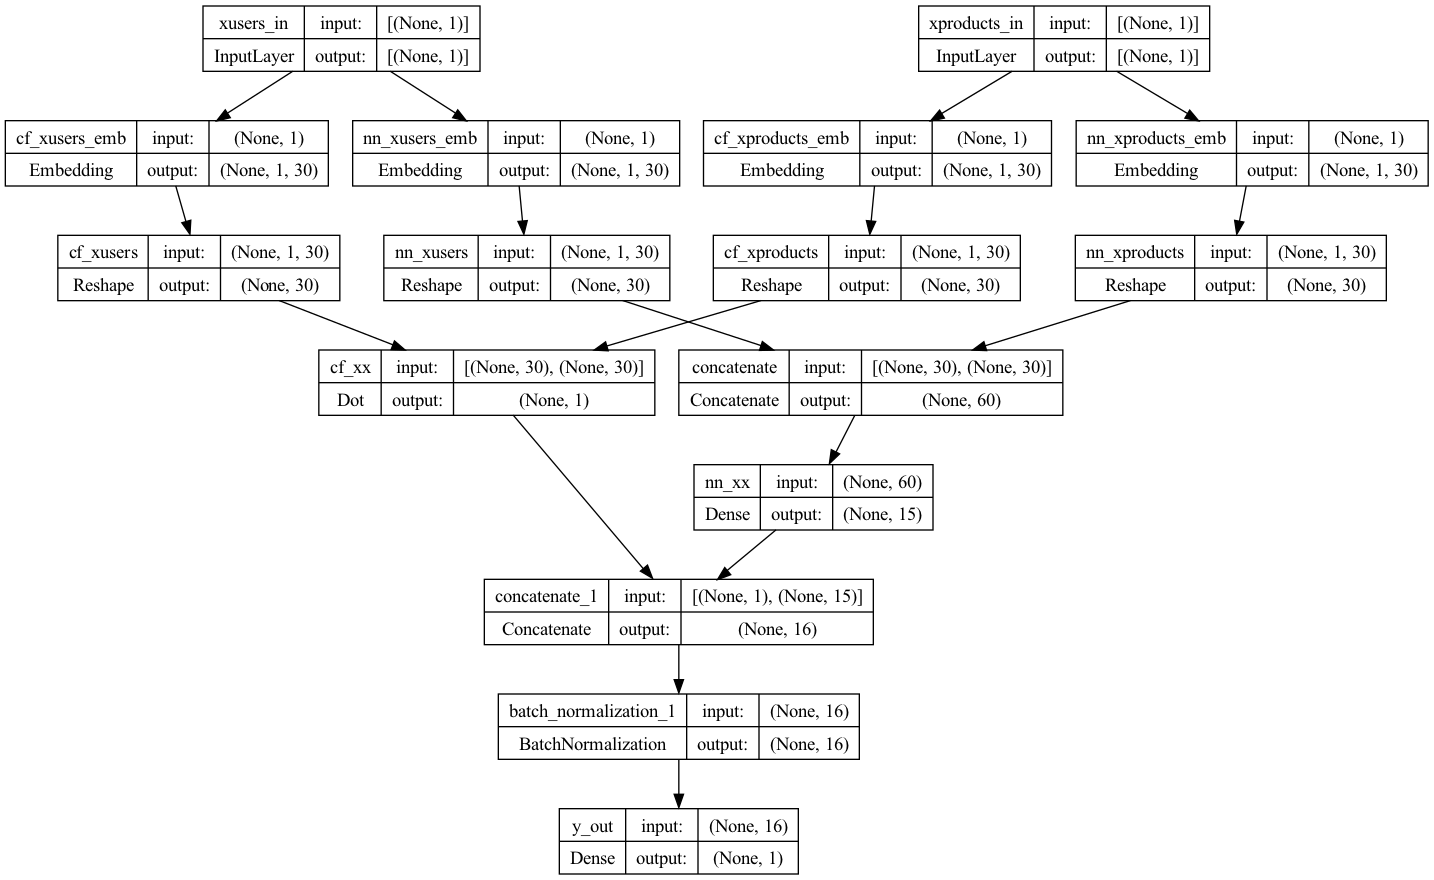

In [59]:
plot_model(model, to_file='ncf.png', show_shapes=True, show_layer_names=True)

In [60]:
# train
ncf_training = model.fit(x=[train["user_id"], train["app_id"]], y=train["y"], 
                     epochs=5, batch_size=128, shuffle=True, verbose=1, validation_data=([test["user_id"], test["app_id"]], test["y"]))

Epoch 1/5
8127/8127 [==============================] - 116s 14ms/step - loss: 0.5392 - accuracy: 0.7209 - val_loss: 0.5726 - val_accuracy: 0.7181
Epoch 2/5
8127/8127 [==============================] - 105s 13ms/step - loss: 0.3703 - accuracy: 0.8401 - val_loss: 0.6117 - val_accuracy: 0.7321
Epoch 3/5
8127/8127 [==============================] - 96s 12ms/step - loss: 0.2702 - accuracy: 0.8944 - val_loss: 0.7076 - val_accuracy: 0.7310
Epoch 4/5
8127/8127 [==============================] - 77s 9ms/step - loss: 0.1965 - accuracy: 0.9297 - val_loss: 0.8284 - val_accuracy: 0.7413
Epoch 5/5
8127/8127 [==============================] - 95s 12ms/step - loss: 0.1454 - accuracy: 0.9515 - val_loss: 0.9483 - val_accuracy: 0.7427


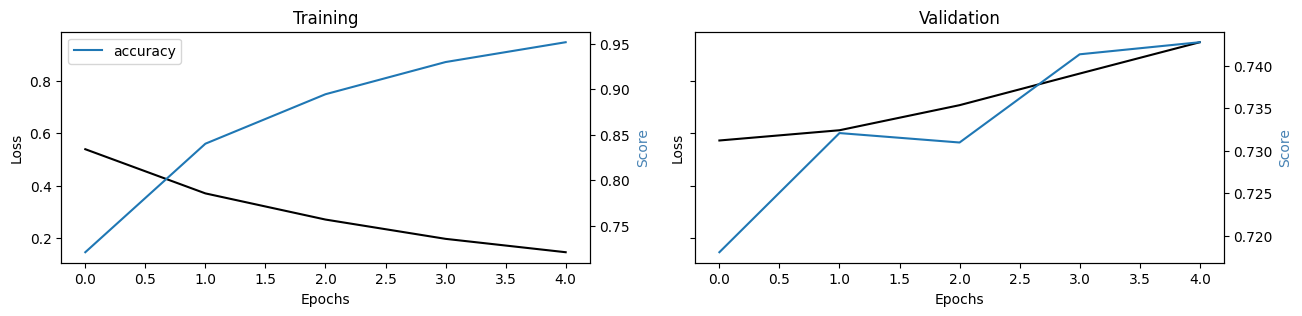

In [61]:
ncf_model = ncf_training.model
utils_plot_keras_training(ncf_training)

In [62]:
# save the model
ncf_model.save('ncf_model.h5')

In [63]:
# test
threshold = 0.5
pred = ncf_model.predict([test["user_id"], test["app_id"]])
binary_pred = np.where(pred >= threshold, 1.0, 0.0)
test["yhat"] = binary_pred
test

1606/1606 [==============================] - 2s 1ms/step


,user_id,app_id,y,yhat
0,1,1515,1.0,1.0
1,1,1536,1.0,1.0
2,1,1726,1.0,1.0
3,4,1708,1.0,1.0
4,5,1530,0.0,0.0
...,...,...,...,...
51384,25304,1747,1.0,1.0
51385,25307,1659,0.0,0.0
51386,25309,1556,1.0,1.0
51387,25310,1546,0.0,1.0


#### Evaluation

In [64]:
# get loss and accuracy on test set
results = ncf_model.evaluate([test["user_id"], test["app_id"]], test["y"], batch_size=128)
print('test loss: ', results[0])
print('test accuracy: ', results[1])

402/402 [==============================] - 0s 935us/step - loss: 0.9483 - accuracy: 0.7427
test loss:  0.9482624530792236
test accuracy:  0.7427465319633484


In [65]:
# Confusion matrix
confusion_matrix(test["y"], test["yhat"])

array([[ 3377,  8230],
       [ 4990, 34792]])

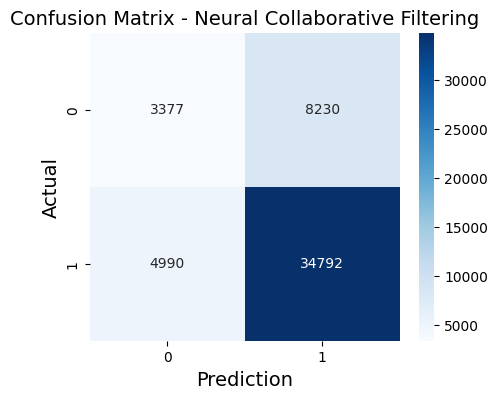

In [66]:
# visualize the confusion matrix with seaborn heatmap
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confusion_matrix(test["y"], test["yhat"]), annot=True, fmt="d", cmap="Blues", cbar=True)
ax.set_xlabel("Prediction", fontsize=14)
ax.set_ylabel("Actual", fontsize=14)
ax.set_title("Confusion Matrix - Neural Collaborative Filtering", fontsize=14)
plt.show()

In [67]:
# classification report
print(classification_report(test["y"], test["yhat"]))

              precision    recall  f1-score   support

         0.0       0.40      0.29      0.34     11607
         1.0       0.81      0.87      0.84     39782

    accuracy                           0.74     51389
   macro avg       0.61      0.58      0.59     51389
weighted avg       0.72      0.74      0.73     51389



### Hybrid Model

In [68]:
# extract data
features = games_cf_df_scaled.columns
print(features)

Index(['win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews',
       'price_final', 'price_original', 'discount', 'Multiplayer', 'Action',
       'Shooter', 'Singleplayer', 'First-Person', 'Horror', 'Adventure',
       'Atmospheric', 'Fantasy', 'Story Rich', 'Puzzle', 'Indie', 'Strategy',
       'Casual', 'Pixel Graphics', '2D', 'Anime', 'RPG', 'Arcade', 'Retro',
       'Female Protagonist', 'Simulation', 'Early Access', 'Cute', 'Funny',
       'Exploration', 'Free to Play', 'Colorful', '3D'],
      dtype='object')


In [69]:
train = oversampled_data

# add features
train = train.merge(games_cf_df_scaled, how="left", left_on="app_id", right_index=True)

train.head()

,user_id,app_id,y,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,Multiplayer,Action,Shooter,Singleplayer,First-Person,Horror,Adventure,Atmospheric,Fantasy,Story Rich,Puzzle,Indie,Strategy,Casual,Pixel Graphics,2D,Anime,RPG,Arcade,Retro,Female Protagonist,Simulation,Early Access,Cute,Funny,Exploration,Free to Play,Colorful,3D
0,0,3,1.0,0.0,1.0,1.0,1.0,0.955224,0.017608,0.124891,0.090826,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,18,1.0,0.0,0.0,0.0,1.0,0.925373,0.000870,0.162395,0.118102,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,55,1.0,0.0,0.0,0.0,0.8,0.805970,0.000258,0.124891,0.090826,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,64,1.0,0.0,0.0,0.0,0.2,0.462687,0.000797,0.124891,0.090826,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,78,1.0,0.0,0.0,0.0,0.8,0.895522,0.003317,0.249906,0.181744,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
train.shape

(1040144, 41)

In [71]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

# add features
test = test.merge(games_cf_df_scaled, how="left", left_on="app_id", right_index=True)

test.head()

,user_id,app_id,y,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,Multiplayer,Action,Shooter,Singleplayer,First-Person,Horror,Adventure,Atmospheric,Fantasy,Story Rich,Puzzle,Indie,Strategy,Casual,Pixel Graphics,2D,Anime,RPG,Arcade,Retro,Female Protagonist,Simulation,Early Access,Cute,Funny,Exploration,Free to Play,Colorful,3D
0,1,1515,1.0,0.0,0.0,0.0,0.8,0.910448,0.003714,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1,1536,1.0,0.0,0.0,0.0,1.0,0.955224,0.005572,0.062383,0.045368,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,1726,1.0,0.0,0.0,0.0,0.4,0.656716,0.006893,0.000000,0.000000,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1708,1.0,0.0,0.0,0.0,1.0,0.925373,0.000163,0.249906,0.181744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,5,1530,0.0,0.0,0.0,0.0,0.8,0.791045,0.006170,0.499937,0.363579,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [72]:
test.shape

(51389, 41)

In [73]:
# Model Design
embeddings_size = 30
usr, prd = user_review_pivot.shape[0], user_review_pivot.shape[1]
feat = len(features)
print("Users", usr, " x  Products", prd, " x  Features", feat)

Users 25311  x  Products 1867  x  Features 38


In [74]:
##### COLLABORATIVE FILTERING #####
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
# embeddings and reshape
cf_xusers_emb = layers.Embedding(
    name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(
    name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
# embeddings and reshape
cf_xproducts_emb = layers.Embedding(
    name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(
    name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
# product
cf_xx = layers.Dot(name='cf_xx', normalize=True,
                   axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
# embeddings and reshape
nn_xusers_emb = layers.Embedding(
    name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(
    name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
# embeddings and reshape
nn_xproducts_emb = layers.Embedding(
    name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(
    name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
# concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(
    embeddings_size/2), activation='relu')(nn_xx)

##### CONTENT BASED ######
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat,
                          activation='relu')(features_in)

##### OUTPUT #####
# Merge all
y = layers.Concatenate()([cf_xx, nn_xx, features_x])

# add batch normalization
y_batch = layers.BatchNormalization()(y)

# Predict ratings (0,1)
y_out = layers.Dense(name="y_out", units=1, activation='sigmoid')(y_batch)

# Compile
model = models.Model(inputs=[xusers_in, xproducts_in,
                     features_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adamax', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 30)        759330      ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 30)        56010       ['xproducts_in[0][0]']           
                                                                                       

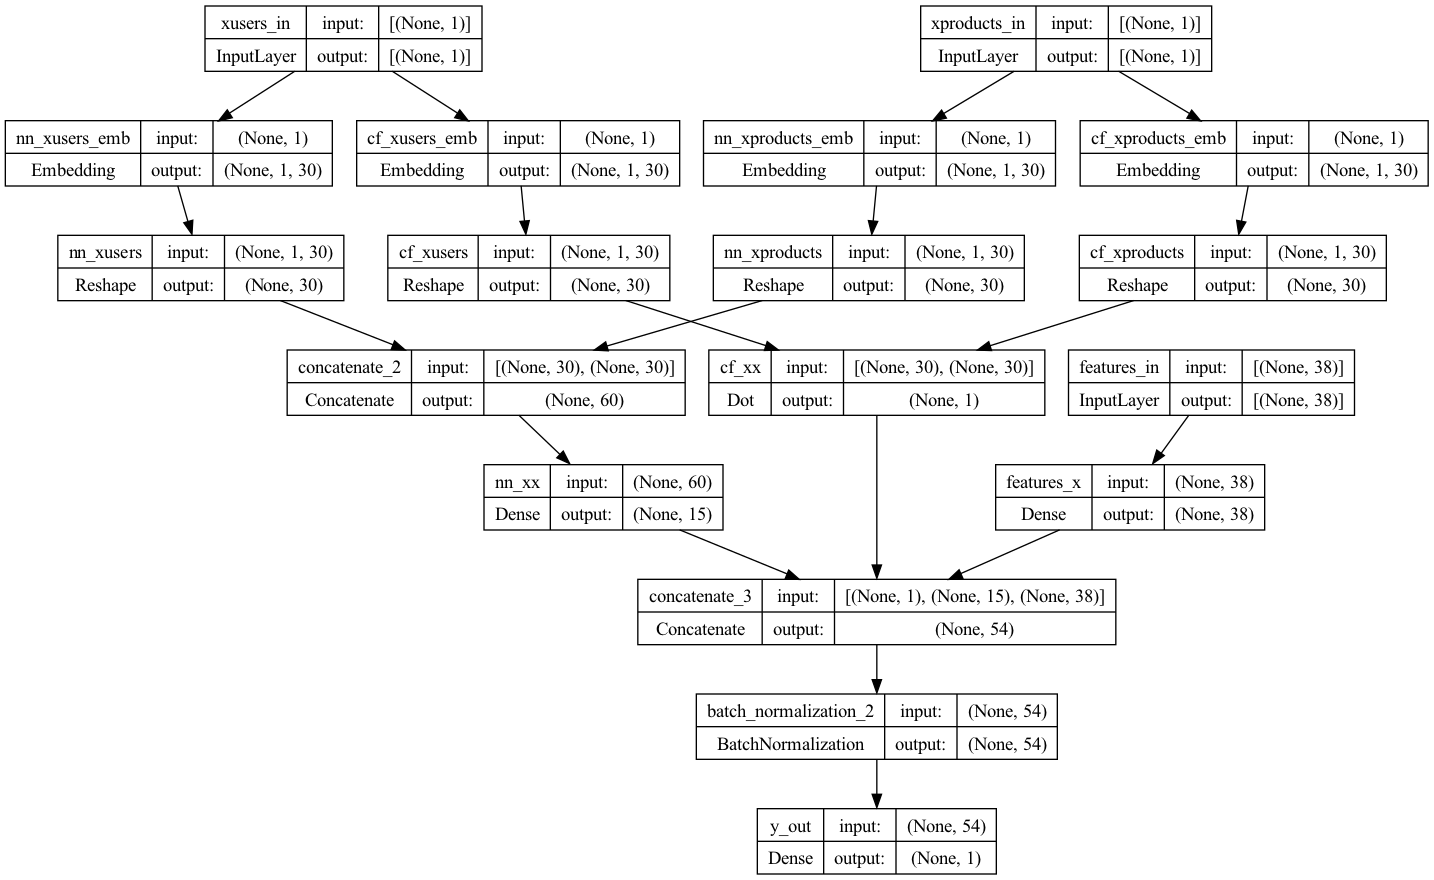

In [75]:
plot_model(model, to_file='hybrid.png', show_shapes=True, show_layer_names=True)

In [76]:
# train
hybrid_training = model.fit(x=[train["user_id"], train["app_id"], train[features]], y=train["y"], epochs=5, batch_size=128, shuffle=True, verbose=1, validation_data=([test["user_id"], test["app_id"], test[features]], test["y"]))

Epoch 1/5
8127/8127 [==============================] - 94s 11ms/step - loss: 0.5351 - accuracy: 0.7249 - val_loss: 0.5178 - val_accuracy: 0.7435
Epoch 2/5
8127/8127 [==============================] - 89s 11ms/step - loss: 0.3685 - accuracy: 0.8407 - val_loss: 0.5649 - val_accuracy: 0.7431
Epoch 3/5
8127/8127 [==============================] - 94s 12ms/step - loss: 0.2687 - accuracy: 0.8952 - val_loss: 0.6553 - val_accuracy: 0.7419
Epoch 4/5
8127/8127 [==============================] - 96s 12ms/step - loss: 0.1953 - accuracy: 0.9303 - val_loss: 0.7698 - val_accuracy: 0.7466
Epoch 5/5
8127/8127 [==============================] - 95s 12ms/step - loss: 0.1438 - accuracy: 0.9521 - val_loss: 0.9021 - val_accuracy: 0.7440


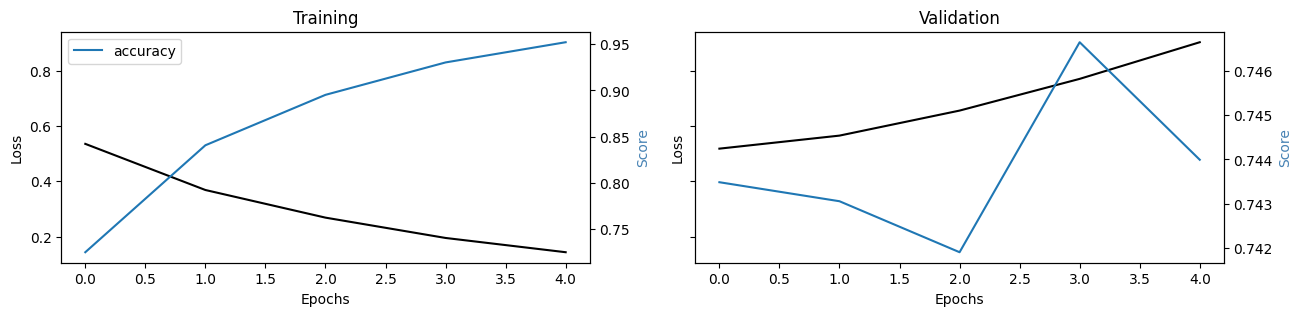

In [77]:
hybrid_model = hybrid_training.model
utils_plot_keras_training(hybrid_training)

In [78]:
# save the model
hybrid_model.save('hybrid_model.h5')

In [79]:
# test
threshold = 0.5
pred = hybrid_model.predict([test["user_id"], test["app_id"], test[features]])
binary_pred = np.where(pred >= threshold, 1.0, 0.0)
test["yhat"] = binary_pred
test


1606/1606 [==============================] - 2s 1ms/step


,user_id,app_id,y,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,Multiplayer,Action,Shooter,Singleplayer,First-Person,Horror,Adventure,Atmospheric,Fantasy,Story Rich,Puzzle,Indie,Strategy,Casual,Pixel Graphics,2D,Anime,RPG,Arcade,Retro,Female Protagonist,Simulation,Early Access,Cute,Funny,Exploration,Free to Play,Colorful,3D,yhat
0,1,1515,1.0,0.0,0.0,0.0,0.8,0.910448,0.003714,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1,1536,1.0,0.0,0.0,0.0,1.0,0.955224,0.005572,0.062383,0.045368,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1,1726,1.0,0.0,0.0,0.0,0.4,0.656716,0.006893,0.000000,0.000000,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,1708,1.0,0.0,0.0,0.0,1.0,0.925373,0.000163,0.249906,0.181744,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5,1530,0.0,0.0,0.0,0.0,0.8,0.791045,0.006170,0.499937,0.363579,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51384,25304,1747,1.0,0.0,0.0,0.0,0.4,0.671642,0.001157,0.374922,0.272661,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51385,25307,1659,0.0,0.0,0.0,0.0,0.8,0.820896,0.007537,0.249906,0.181744,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
51386,25309,1556,1.0,0.0,0.0,0.0,1.0,0.940299,0.001291,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51387,25310,1546,0.0,0.0,0.0,0.0,0.8,0.791045,0.005028,0.299912,0.363579,0.444444,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


#### Evaluation

In [80]:
# get loss and accuracy on test set
results = hybrid_model.evaluate([test["user_id"], test["app_id"], test[features]], test["y"], batch_size=128)
print('test loss: ', results[0])
print('test accuracy: ', results[1])

402/402 [==============================] - 1s 1ms/step - loss: 0.9021 - accuracy: 0.7440
test loss:  0.9021410942077637
test accuracy:  0.7439919114112854


In [81]:
# Confusion matrix
confusion_matrix(test["y"], test["yhat"])

array([[ 4001,  7606],
       [ 5550, 34232]])

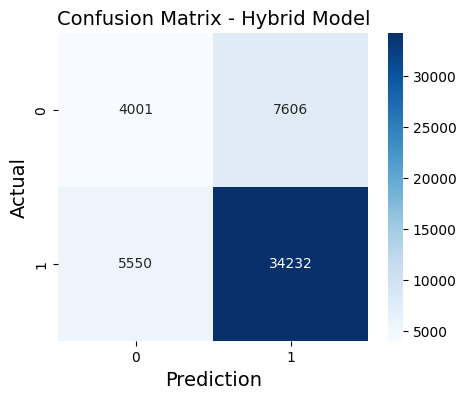

In [82]:
# visualize the confusion matrix with seaborn heatmap
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confusion_matrix(test["y"], test["yhat"]), annot=True, fmt="d", cmap="Blues", cbar=True)
ax.set_xlabel("Prediction", fontsize=14)
ax.set_ylabel("Actual", fontsize=14)
ax.set_title("Confusion Matrix - Hybrid Model", fontsize=14)
plt.show()

In [83]:
# classification report
print(classification_report(test["y"], test["yhat"]))

              precision    recall  f1-score   support

         0.0       0.42      0.34      0.38     11607
         1.0       0.82      0.86      0.84     39782

    accuracy                           0.74     51389
   macro avg       0.62      0.60      0.61     51389
weighted avg       0.73      0.74      0.73     51389



## Model Selection and Improvement

Based on the performance of the models above, I choose the Hybrid Model as our final model. We will further improve the model by tuning the hyperparameters.

## Model Evaluation